# **World Happiness Report 2019 with School enrollment & Inflation**

---



## **Abstract**

**Context**
> In years, some economic indicators (e.g. GDP per capita or income level) have been believed to have a positive relationship with people’s happiness across nations. World Happiness Report 2019 considers six indicators related to people’s happiness: GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices, Generosity and Perceptions of corruption. While recently, some studies found that: education is positively correlated with happiness and inflation has a negative impact on people’s happiness. 


---


**Content**


> We use the World Happiness Report 2019, containing data from 150 countries in the world(https://www.kaggle.com/datasets/unsdsn/world-happiness?select=2019.csv2Links) and 6 life indicators to analyze their effect on life happiness. We also import additional 4 datasets from the World Bank Data: 
1. school enrollment primary 2019
2. school enrollment secondary 2019(https://data.worldbank.org/indicator/SE.SEC.ENRR)
3. school enrollment tertiary 2019(https://data.worldbank.org/indicator/SE.TER.ENRR?view=chartLinks)
4. Inflation & CPI 2019(https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?view=chartLinks)
With these datasets, we will explore what indicator affects the happiness of life the most.


---


**Target**
> The aims of this study:
  1.	To analyze the relationship between countries' happiness and six indicators proposed by World Happiness Report, together with 4 self-added indicators (school enrollment in primary, secondary, tertiary, and inflation).
  2.	To establish a predictive model with related predictive indicators.

## **Data preprocess**

In [ ]:
!pip install shap
!pip install h2o

In [446]:
import shap

import sklearn
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm

import pandas as pd
import numpy as np
from numpy import arange

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

### Customize functions for filling NaN cells

In [447]:
# ------------------------------------------------------------------------------------
# Search all "NaN" in WHR
def search_zero_country(data, col):
	line_number = 0
	list_of_countries = []
	for r in data[col]:
		if r == 0:
			list_of_countries.append(data["Country or region"][line_number])
		line_number += 1

	return list_of_countries
# ------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------
# Extract all countries from the same region and income group
def countries_in_region(data, country):
  # find the region and income group of this country
  index = 0
  region_group = []
  for c in data["TableName"]:
    if c == country:
      if data["Region"][index] == '':
        break
      else:
        region_group = [data["Region"][index], data["IncomeGroup"][index]]
        break
    index += 1
  
  # find list of countries belong to this region and income group
  list_of_countries = []
  index = 0
  for c in data["TableName"]:
    if data["Region"][index] == region_group[0] and data["IncomeGroup"][index] == region_group[1]:
      list_of_countries.append(c)
    index += 1

  if(country in list_of_countries):
    list_of_countries.remove(country)
  
  return list_of_countries
# ------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------
# Calculate Mean School Enrollment of the same region and income group and replace in WHR
def getMean(data, list_of_countries, country, col):
  index_country = -1
  index = 0
  sum = 0
  size = 0
  for cname in data["Country or region"]:
      if cname == country:
        index_country = index
      if cname in list_of_countries and data[col][index] != 0:
        sum += data[col][index]
        size += 1
      index += 1

  # Replace data in WHR
  if size != 0:
    data.at[index_country, col] = sum / size
# ------------------------------------------------------------------------------------


# ------------------------------------------------------------------------------------
# Replace NaN cell in WHR
def datareplace(data, region, list_of_countries_zero, col):
  for c in list_of_countries_zero:
    list_of_countries_same = countries_in_region(region, c)
    getMean(data, list_of_countries_same, c, col)
# ------------------------------------------------------------------------------------

### Part1 - Missing value filling

Import dataset from World Happiness Report 2019 with **School enrollment 2019(Primary)**, **School enrollment 2019(Secondary)**, **School enrollment 2019(Tertiary)** and **Inflation & CPI 2019**. 


> There are some null cell in the WHR data. Before I import the WHR, I have replaced some of null data in WHR with data in *2018* or *2020* in Excel manually. The remaining null cell should be replaced by the mean value of data from all countries in the same region and the same income group with python.
So we need to import dataset from **School Enrollment 2019** & **Country Region**





In [448]:
# Import dataset "World Happiness Report"
WHR_url = 'https://raw.githubusercontent.com/YongyanDeng/Word_Happiness_Report/main/data/World_Happiness_Report_2019.csv'
WHR = pd.read_csv(WHR_url)
WHR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  150 non-null    int64  
 1   Country or region             150 non-null    object 
 2   Score                         150 non-null    float64
 3   GDP per capita                150 non-null    float64
 4   Social support                150 non-null    float64
 5   Healthy life expectancy       150 non-null    float64
 6   Freedom to make life choices  150 non-null    float64
 7   Generosity                    150 non-null    float64
 8   Perceptions of corruption     150 non-null    float64
 9   SE_PRM_2019                   150 non-null    float64
 10  SE_SEC_2019                   150 non-null    float64
 11  SE_TER_2019                   150 non-null    float64
 12  FPCPI_2019                    150 non-null    float64
dtypes: fl

In [449]:
WHR

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,99.915733,145.318985,92.955009,1.024094
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,100.267670,129.885025,81.839760,0.758132
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,100.215332,118.620163,83.230690,2.167730
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,100.969353,115.444962,77.588837,3.013972
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,106.095818,134.358734,87.097847,2.633699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,131.311874,44.319038,6.235390,3.347877
146,147,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,96.274467,30.831770,3.092500,3.464281
147,148,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,106.701080,55.425209,9.686420,2.302373
148,149,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,0.000000,0.000000,0.000000,2.685374


#### Fill "SE_PRM_2019" with data of countries from the same region & income group

In [450]:
# Import SE_PRM Region dataset
SE_PRM_REGION = pd.read_csv('https://raw.githubusercontent.com/YongyanDeng/Word_Happiness_Report/main/data/SE_Prm/Metadata_Country_API_SE.PRM.ENRR_DS2_en_csv_v2_4666459.csv')
SE_PRM_REGION

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN
...,...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo,NaN
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep.",NaN
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa,NaN
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia,NaN


In [451]:
list_of_countries_zero = search_zero_country(WHR, "SE_PRM_2019")
list_of_countries_zero

['El Salvador',
 'Trinidad and Tobago',
 'Nicaragua',
 'Kosovo',
 'Jamaica',
 'Japan',
 'Honduras',
 'Paraguay',
 'Libya',
 'Bosnia and Herzegovina',
 'Lebanon',
 'Gabon',
 'Somalia',
 'Kenya',
 'Iraq',
 'Ukraine',
 'Haiti',
 'Botswana',
 'Central African Republic',
 'South Sudan']

In [452]:
datareplace(WHR, SE_PRM_REGION, list_of_countries_zero, "SE_PRM_2019")
WHR

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,99.915733,145.318985,92.955009,1.024094
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,100.267670,129.885025,81.839760,0.758132
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,100.215332,118.620163,83.230690,2.167730
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,100.969353,115.444962,77.588837,3.013972
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,106.095818,134.358734,87.097847,2.633699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,131.311874,44.319038,6.235390,3.347877
146,147,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,96.274467,30.831770,3.092500,3.464281
147,148,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,106.701080,55.425209,9.686420,2.302373
148,149,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,109.230540,0.000000,0.000000,2.685374


#### Fill "SE_SEC_2019" with data of countries from the same region & income group

In [453]:
SE_SEC_REGION = pd.read_csv('https://raw.githubusercontent.com/YongyanDeng/Word_Happiness_Report/main/data/SE_Sec/Metadata_Country_API_SE.SEC.ENRR_DS2_en_csv_v2_4672725.csv')
SE_SEC_REGION

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN
...,...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo,NaN
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep.",NaN
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa,NaN
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia,NaN


In [454]:
list_of_countries_zero = search_zero_country(WHR, "SE_SEC_2019")
list_of_countries_zero

['Qatar',
 'Panama',
 'El Salvador',
 'Trinidad and Tobago',
 'Nicaragua',
 'Kosovo',
 'Kuwait',
 'Jamaica',
 'Japan',
 'Honduras',
 'Paraguay',
 'Libya',
 'Tajikistan',
 'Bosnia and Herzegovina',
 'Algeria',
 'Lebanon',
 'China',
 'Vietnam',
 'Cameroon',
 'Congo, Rep.',
 'Gabon',
 'Somalia',
 'Namibia',
 'Niger',
 'Guinea',
 'Gambia, The',
 'Kenya',
 'Mozambique',
 'Tunisia',
 'Iraq',
 'Congo, Dem. Rep.',
 'Sierra Leone',
 'Ukraine',
 'Ethiopia',
 'Eswatini',
 'Uganda',
 'Zambia',
 'Togo',
 'Liberia',
 'Lesotho',
 'Zimbabwe',
 'Haiti',
 'Botswana',
 'Central African Republic',
 'South Sudan']

In [455]:
datareplace(WHR, SE_SEC_REGION, list_of_countries_zero, "SE_SEC_2019")
WHR

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,99.915733,145.318985,92.955009,1.024094
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,100.267670,129.885025,81.839760,0.758132
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,100.215332,118.620163,83.230690,2.167730
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,100.969353,115.444962,77.588837,3.013972
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,106.095818,134.358734,87.097847,2.633699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,131.311874,44.319038,6.235390,3.347877
146,147,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,96.274467,30.831770,3.092500,3.464281
147,148,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,106.701080,55.425209,9.686420,2.302373
148,149,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,109.230540,37.712017,0.000000,2.685374


#### Fill "SE_TER_2019" with data of countries from the same region & income group

In [456]:
# Import SE_SEC Region dataset
SE_TER_REGION = pd.read_csv('https://raw.githubusercontent.com/YongyanDeng/Word_Happiness_Report/main/data/SE_Ter/Metadata_Country_API_SE.TER.ENRR_DS2_en_csv_v2_4690952.csv')
SE_TER_REGION

,Country Code,Region,IncomeGroup,SpecialNotes,TableName
0,ABW,Latin America & Caribbean,High income,NaN,Aruba
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola
...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep."
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia


In [457]:
list_of_countries_zero = search_zero_country(WHR, "SE_TER_2019")
list_of_countries_zero

['Panama',
 'Trinidad and Tobago',
 'Kosovo',
 'Thailand',
 'Jamaica',
 'Japan',
 'Bolivia',
 'Paraguay',
 'Peru',
 'Libya',
 'Tajikistan',
 'Lebanon',
 'Congo, Rep.',
 'Somalia',
 'Gambia, The',
 'Iraq',
 'Congo, Dem. Rep.',
 'Mali',
 'Sierra Leone',
 'Chad',
 'Ukraine',
 'Eswatini',
 'Uganda',
 'Zambia',
 'Liberia',
 'Comoros',
 'Zimbabwe',
 'Haiti',
 'Central African Republic']

In [458]:
datareplace(WHR, SE_TER_REGION, list_of_countries_zero, "SE_TER_2019")
WHR

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,99.915733,145.318985,92.955009,1.024094
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,100.267670,129.885025,81.839760,0.758132
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,100.215332,118.620163,83.230690,2.167730
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,100.969353,115.444962,77.588837,3.013972
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,106.095818,134.358734,87.097847,2.633699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,131.311874,44.319038,6.235390,3.347877
146,147,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,96.274467,30.831770,3.092500,3.464281
147,148,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,106.701080,55.425209,9.686420,2.302373
148,149,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,109.230540,37.712017,6.158263,2.685374


#### Fill Inflation & CPI

In [459]:
FPCPI_REGION = pd.read_csv('https://raw.githubusercontent.com/YongyanDeng/Word_Happiness_Report/main/data/Inflation_Consumer_price_2019/Metadata_Country_API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_4690188.csv')
FPCPI_REGION

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN
...,...,...,...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income,NaN,Kosovo,NaN
261,YEM,Middle East & North Africa,Low income,The World Bank systematically assesses the app...,"Yemen, Rep.",NaN
262,ZAF,Sub-Saharan Africa,Upper middle income,Fiscal year end: March 31; reporting period fo...,South Africa,NaN
263,ZMB,Sub-Saharan Africa,Low income,National accounts data were rebased to reflect...,Zambia,NaN


In [460]:
list_of_countries_zero = search_zero_country(WHR, "FPCPI_2019")
list_of_countries_zero

['Uzbekistan',
 'Argentina',
 'Libya',
 'Tajikistan',
 'Turkmenistan',
 'Somalia',
 'Congo, Dem. Rep.',
 'Comoros']

In [461]:
datareplace(WHR, FPCPI_REGION, list_of_countries_zero, "FPCPI_2019")
WHR

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,99.915733,145.318985,92.955009,1.024094
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,100.267670,129.885025,81.839760,0.758132
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,100.215332,118.620163,83.230690,2.167730
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,100.969353,115.444962,77.588837,3.013972
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,106.095818,134.358734,87.097847,2.633699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,131.311874,44.319038,6.235390,3.347877
146,147,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,96.274467,30.831770,3.092500,3.464281
147,148,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,106.701080,55.425209,9.686420,2.302373
148,149,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,109.230540,37.712017,6.158263,2.685374


### Part2 - Data Cleaning

> In the beginning, I delete "**Overall rank**" column, which is useless to the prediction. Besides, "**Country or region**" will be remained as a label column for further visualizing

In [462]:
WHR.drop("Overall rank", axis=1, inplace=True)
WHR

,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,99.915733,145.318985,92.955009,1.024094
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,100.267670,129.885025,81.839760,0.758132
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,100.215332,118.620163,83.230690,2.167730
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,100.969353,115.444962,77.588837,3.013972
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,106.095818,134.358734,87.097847,2.633699
...,...,...,...,...,...,...,...,...,...,...,...,...
145,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,131.311874,44.319038,6.235390,3.347877
146,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,96.274467,30.831770,3.092500,3.464281
147,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,106.701080,55.425209,9.686420,2.302373
148,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,109.230540,37.712017,6.158263,2.685374


## **Score of Happiness 2019**

### Happy & Unhappy Countries



> I divided all 150 countries into two categories according to whether the score is above the average: happy countries and unhappy countries.



In [463]:
# mean == 5.435906666666667
mean_score = WHR['Score'].mean()  
data = WHR.copy()
data["groupby_meanscore"] = data['Score'].map(lambda x: 2 if x < mean_score else 1)
data

,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019,groupby_meanscore
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,99.915733,145.318985,92.955009,1.024094,1
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,100.267670,129.885025,81.839760,0.758132,1
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,100.215332,118.620163,83.230690,2.167730,1
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,100.969353,115.444962,77.588837,3.013972,1
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,106.095818,134.358734,87.097847,2.633699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,131.311874,44.319038,6.235390,3.347877,2
146,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,96.274467,30.831770,3.092500,3.464281,2
147,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,106.701080,55.425209,9.686420,2.302373,2
148,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,109.230540,37.712017,6.158263,2.685374,2


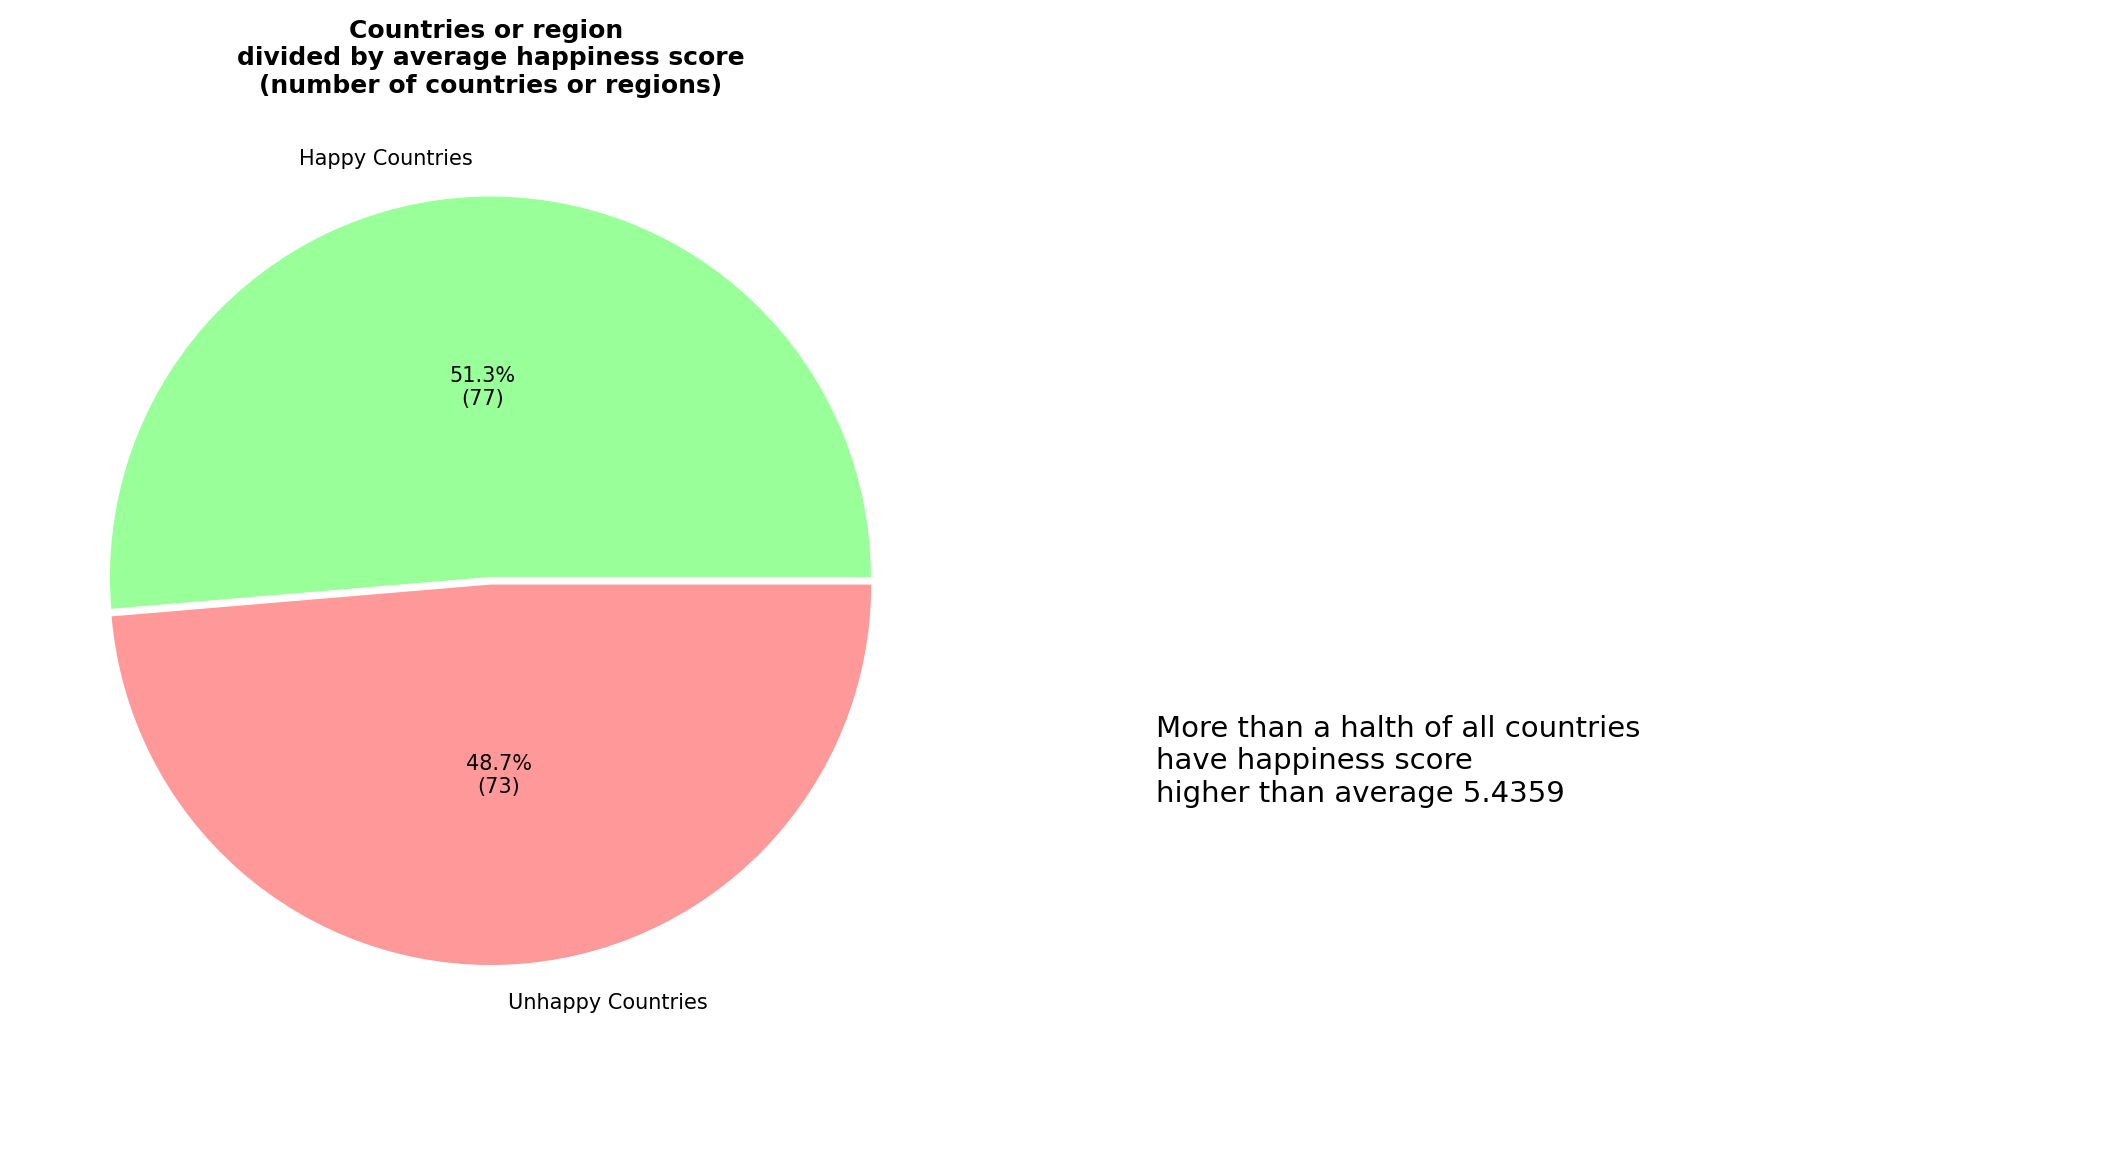

In [464]:
#group by mean score for pieplots - to show not only %% but also value
groupby_score_mean_cntry = data.groupby('groupby_meanscore')["Country or region"].count().sort_values(ascending =False)

fig, axs = plt.subplots(1,2, figsize=(18, 10), dpi = 150 )

labels = ['Happy Countries', 'Unhappy Countries']
explode=[0.01] * 2
colors = ['#99ff99', '#ff9999'] #Mint Green, lightsalmonpink

def fu(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals))) 
    return "{:.1f}%\n({:.0f})".format(pct, absolute)


axs[0].pie(groupby_score_mean_cntry,  explode=explode,  pctdistance=0.5, labels = labels, colors=colors,
          autopct=lambda pct: fu(pct, groupby_score_mean_cntry) ) #autopct= '%1.1f%%',
axs[0].set_title('Countries or region \ndivided by average happiness score\n(number of countries or regions)',  fontweight = 'bold')

axs[1].text(0,0.3,'More than a halth of all countries \nhave happiness score \nhigher than average 5.4359', fontweight='normal',fontsize=14, weight='light',color='black', va ='bottom')

axs[1].set_yticklabels('')
axs[1].set_xticklabels('')
axs[1].tick_params(axis='y',length=0)
axs[1].tick_params(axis='x',length=0)
for line in ['top','right','left','bottom']:
    axs[1].spines[line].set_visible(False)

plt.show()

### Life Index and Happiness Score

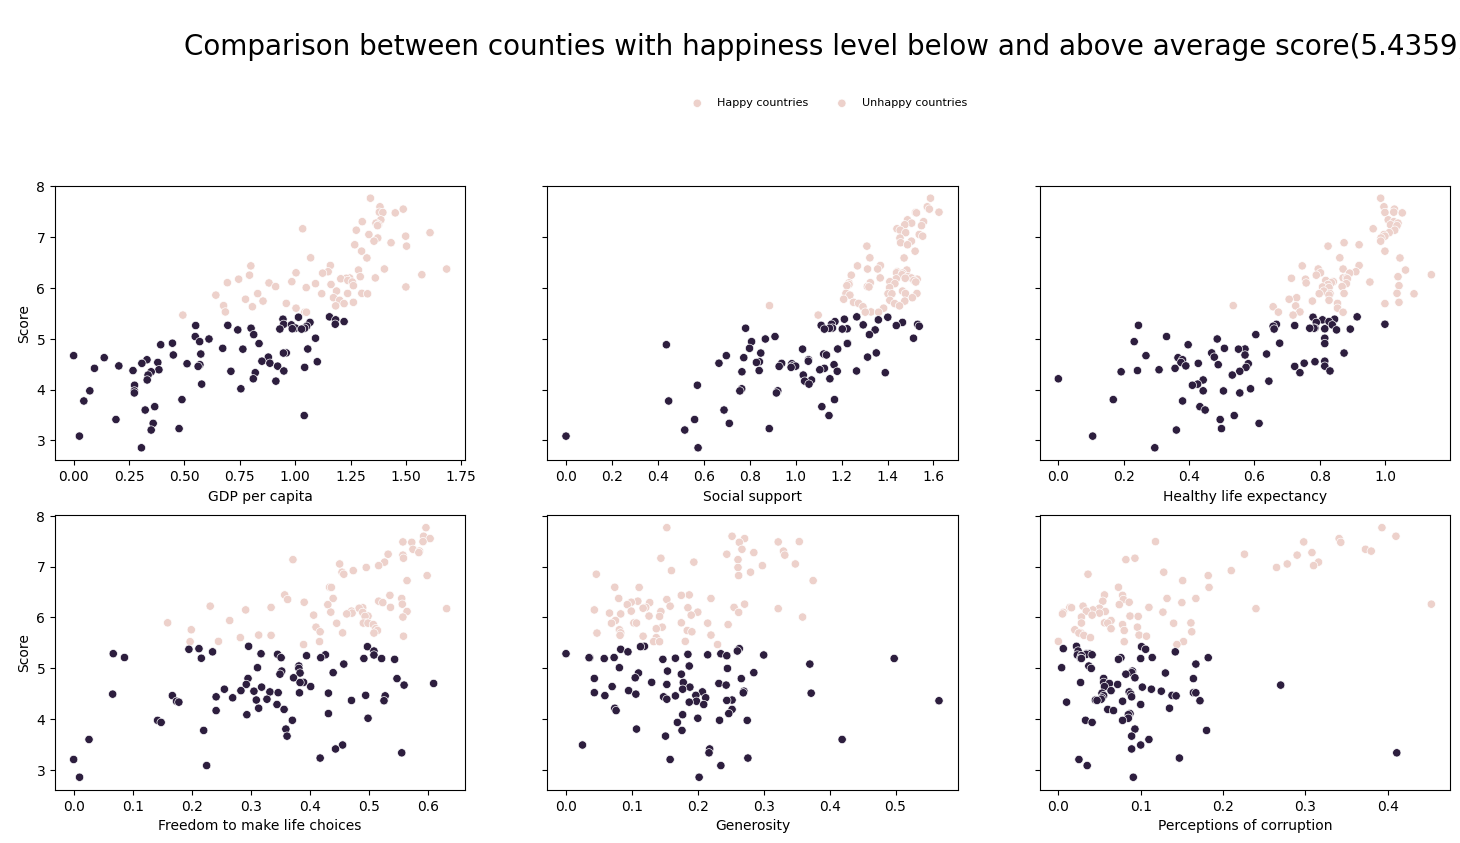

In [465]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True, dpi = 100 )


sns.scatterplot(ax = axes[0,0], y ='Score',  x ='GDP per capita', \
                hue = 'groupby_meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[0,1], y ='Score',  x ='Social support', \
                hue = 'groupby_meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[0,2], y ='Score',  x ='Healthy life expectancy', \
                hue = 'groupby_meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[1,0], y ='Score',  x ='Freedom to make life choices', \
                hue = 'groupby_meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[1,1], y ='Score',  x ='Generosity', \
                hue = 'groupby_meanscore', data = data, legend = False)
sns.scatterplot(ax = axes[1,2], y ='Score',  x ='Perceptions of corruption', \
                hue = 'groupby_meanscore', data = data, legend = False)


fig.legend(loc='upper left', bbox_to_anchor= (0.1,1.1), ncol=2,\
           borderaxespad=0, frameon=False, title_fontsize=20, fontsize=8,
          title='The relationship of happiness Score and 6 life evaluated factors.\n\
          \nComparison between counties with happiness level below and above average score(5.4359)\n', \
           labels=["Happy countries", 'Unhappy countries'],  )

plt.show()


> As we can see, “**GDP per capita**”, “**Social support**”, “**Healthy life expectancy**”, “**Freedom to make life choices**” and “**Perceptions of corruption**” strongly reflect the happiness of life; But “**Generosity**” has a week influence to score



### Education and Happiness Score

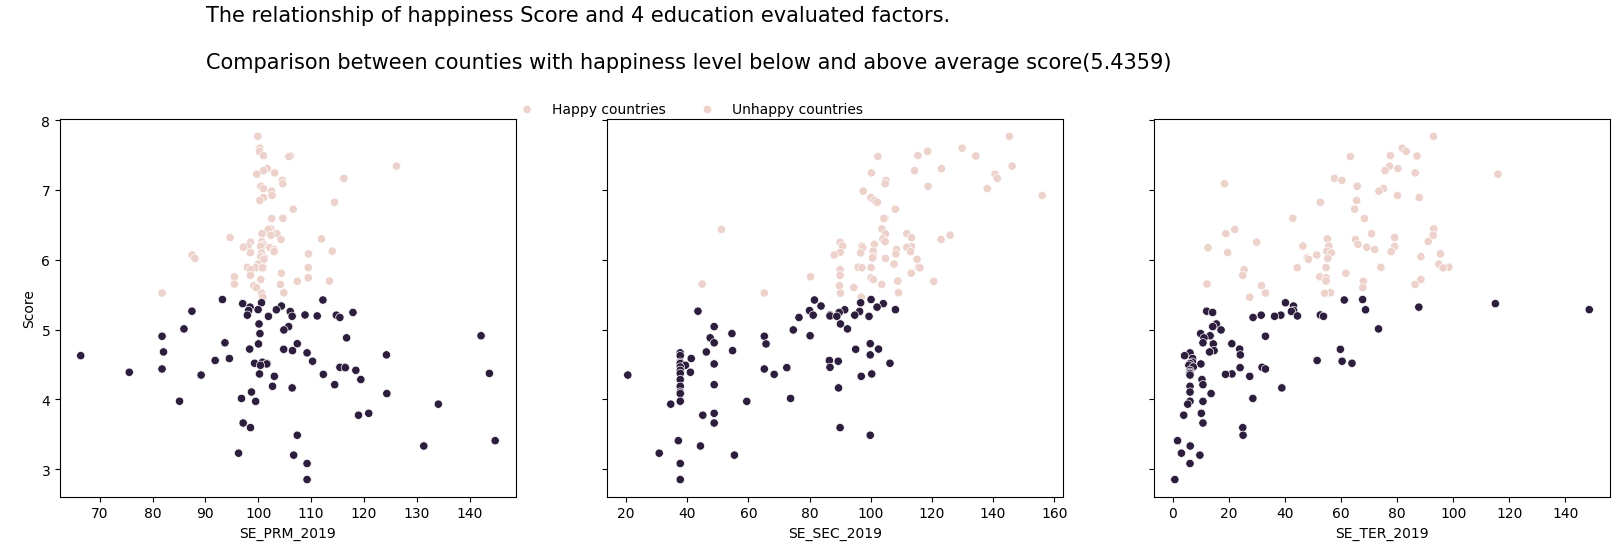

In [466]:
fig2, axes2 = plt.subplots(1, 3, figsize=(20, 5), sharey=True, dpi = 100 )


sns.scatterplot(ax = axes2[0], y ='Score',  x ='SE_PRM_2019', \
                hue = 'groupby_meanscore', data = data, legend = False)
sns.scatterplot(ax = axes2[1], y ='Score',  x ='SE_SEC_2019', \
                hue = 'groupby_meanscore', data = data, legend = False)
sns.scatterplot(ax = axes2[2], y ='Score',  x ='SE_TER_2019', \
                hue = 'groupby_meanscore', data = data, legend = False)


fig2.legend(loc='upper left', bbox_to_anchor= (0.1,1.1), ncol=2,\
           borderaxespad=0, frameon=False, title_fontsize=15, fontsize=10,
          title='The relationship of happiness Score and 4 education evaluated factors.\n\
          \nComparison between counties with happiness level below and above average score(5.4359)\n', \
           labels=["Happy countries", 'Unhappy countries'],  )

plt.show()



> The graph above shows that school enrollment in secondary and tertiary have an effect on happiness score and secondary school enrollment affects the score significantly. 

> Because these 3 data are gross school enrollment, and when the enrollment is higher than 100%, it reflects that many students are not able to finish their studies in their grade and have to repeat. To a certain extent, it reflects the lower educational level and educational conditions in these countries. And grade repetition happens more frequently in the primary school phase than in other phases.





### Inflation & CPI and Happiness Score

In [467]:
mean_cpi = WHR['FPCPI_2019'].mean() 
print(f"Mean CPI = {mean_cpi}%")
data["group_by_cpi"] = data['FPCPI_2019'].map(lambda x: 'Low CPI' if x < mean_cpi else 'High CPI')

Mean CPI = 5.834873840318281%


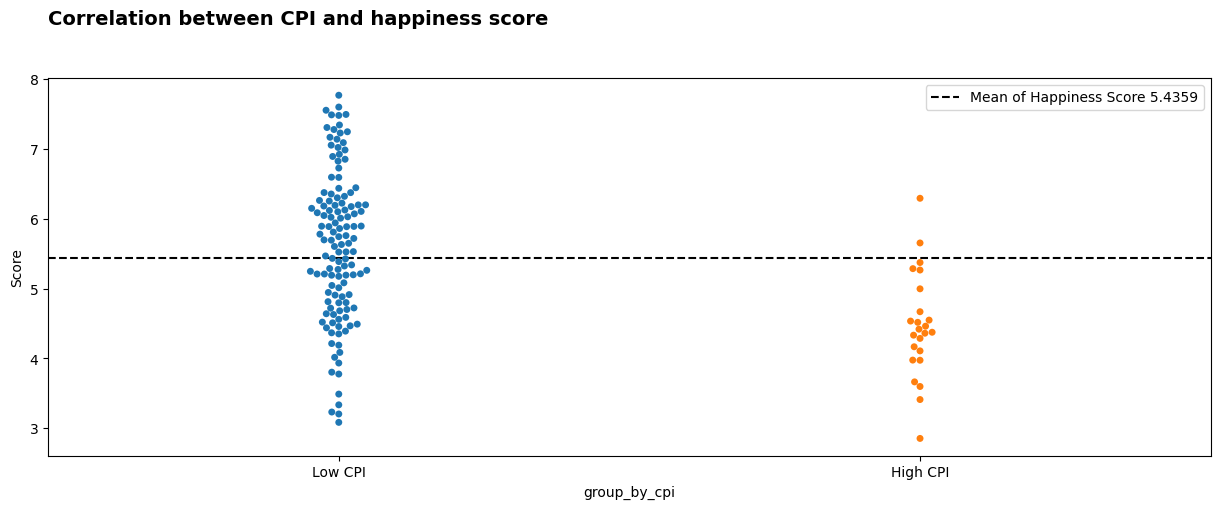

In [519]:
fig = plt.figure(figsize=(15,5),dpi=100)
widths = [2]

gs = fig.add_gridspec(ncols = 1, nrows = 1, width_ratios=widths)
gs.update(wspace=0.05, hspace=0.27)  # <--- wwigth between  cells og the fig (figure)
ax0 = fig.add_subplot(gs[0])


sns.swarmplot(x= data['group_by_cpi'],  y= data['Score'], ax = ax0)
ax0.axhline(mean_score, ls='--', c='black',label='Mean of Happiness Score 5.4359')

ax0.text(-0.5,9,'Correlation between CPI and happiness score',
         fontfamily='sans-serif',fontsize=14,fontweight='bold',color='black',
        horizontalalignment='left',  verticalalignment='top') 

plt.legend()
plt.show()


> Generally, compared to people in countries with low CPI, people who suffer from high CPI is harder to achieve life happiness; Although more than half of the countries with low CPI have happiness score above the average, there are still many countries with low CPI get lower happiness score. That means low CPI cannot guarantee a high happiness score.



## **Feature Selection**

### Part1 - Data Normalizing

In [469]:
Y = ["Score"]
X = [c for c in WHR.columns if c not in Y]
X.remove("Country or region")
X

['GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'SE_PRM_2019',
 'SE_SEC_2019',
 'SE_TER_2019',
 'FPCPI_2019']

<Figure size 576x360 with 0 Axes>

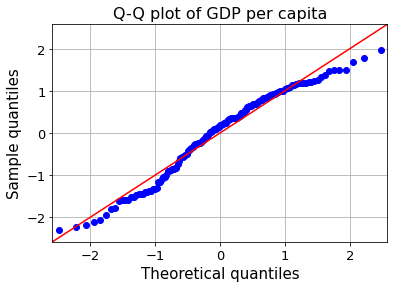

<Figure size 576x360 with 0 Axes>

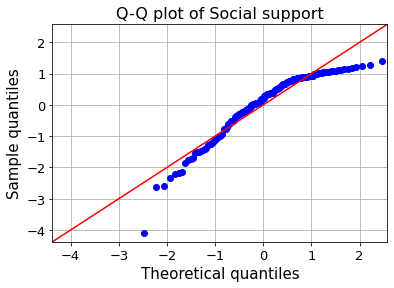

<Figure size 576x360 with 0 Axes>

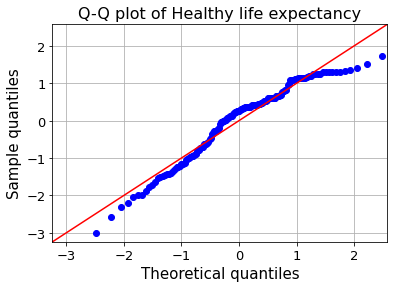

<Figure size 576x360 with 0 Axes>

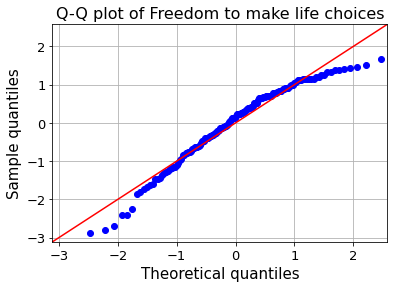

<Figure size 576x360 with 0 Axes>

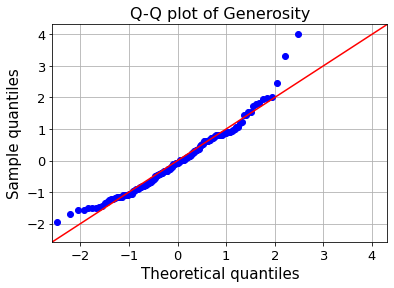

<Figure size 576x360 with 0 Axes>

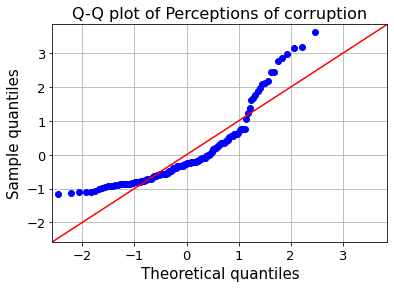

<Figure size 576x360 with 0 Axes>

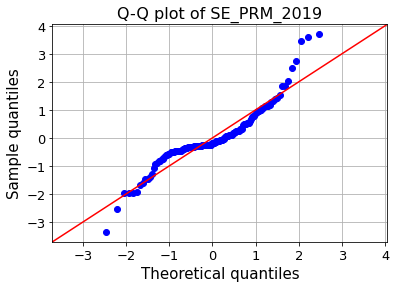

<Figure size 576x360 with 0 Axes>

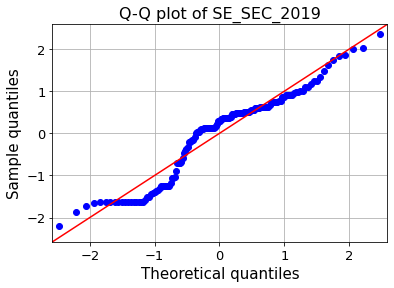

<Figure size 576x360 with 0 Axes>

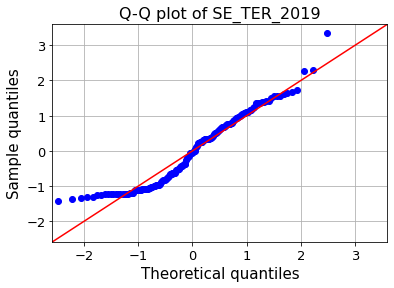

<Figure size 576x360 with 0 Axes>

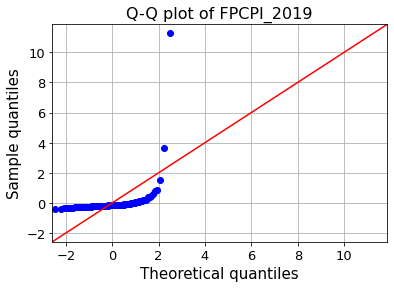

<Figure size 576x360 with 0 Axes>

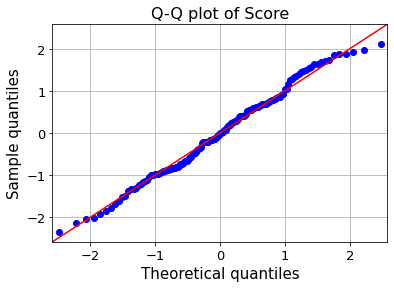

In [470]:
#checking the distribution of independent variables
from statsmodels.graphics.gofplots import qqplot
WHR_norm=WHR[X + Y]
for c in WHR_norm.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(WHR_norm[c],line='45',fit='True')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot of {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()



> 1. Looking at the Q-Q plot above, it appears that all independent variables are roughly following normal distribution.
> 2. There are few outliers in few of the predictor variables like in **"FPCPI_2019"**, **"Generosity"** and **"SE_PRM_2019"**









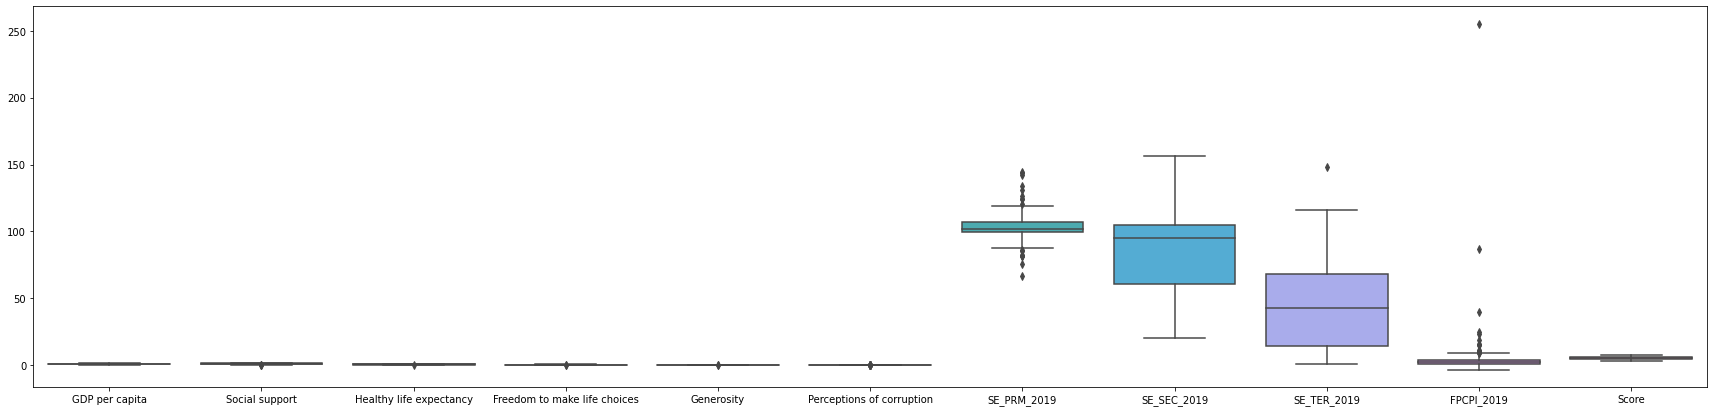

In [471]:
#Checking the Ranges of the predictor variables and dependent variable
plt.figure(figsize=(30,7))
sns.boxplot(data=WHR[X + Y])


> It is hard to visualize and read data as they are not in same ranges, I'll try to normalize all features for a better understanding and visualization. It will also help later to get normalized coeffiecients when building the Model.



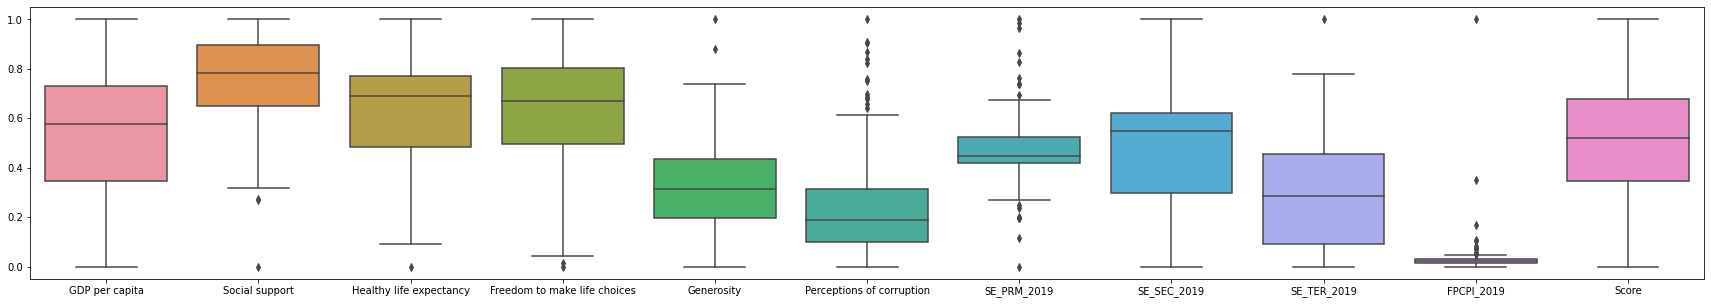

In [472]:
# Instead of normalizing a few variables, I normalize all
import copy
WHR_std = copy.deepcopy(WHR[X + Y]);
WHR_std = pd.get_dummies(WHR_std)

from sklearn import preprocessing

for i in range(0, 11):
  t = WHR_std[[WHR_std.columns[i]]].values.astype(WHR_std.dtypes[i])

  min_max_scaler = preprocessing.MinMaxScaler()

  t_scaled = min_max_scaler.fit_transform(t)
  WHR_std[[WHR_std.columns[i]]] = pd.DataFrame(t_scaled)

plt.figure(figsize=(30,5))
sns.boxplot(data=WHR_std)

In [473]:
WHR_std.insert(0, "Country or region", WHR['Country or region'], allow_duplicates=True)
WHR_std

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019,Score
0,Finland,0.795724,0.977217,0.864154,0.944532,0.270318,0.867550,0.427324,0.920593,0.623931,0.016468,1.000000
1,Denmark,0.821259,0.968596,0.872918,0.938193,0.445230,0.905077,0.431813,0.806711,0.548717,0.015439,0.965622
2,Norway,0.883610,0.974138,0.900964,0.955626,0.478799,0.752759,0.431146,0.723591,0.558129,0.020891,0.956265
3,Iceland,0.819477,1.000000,0.899211,0.936609,0.625442,0.260486,0.440764,0.700162,0.519952,0.024164,0.944060
4,Netherlands,0.828979,0.937192,0.875548,0.882726,0.568905,0.657837,0.506156,0.839721,0.584297,0.022693,0.942840
...,...,...,...,...,...,...,...,...,...,...,...,...
145,Rwanda,0.213183,0.437808,0.538124,0.879556,0.383392,0.907285,0.827808,0.175347,0.037120,0.025456,0.097844
146,Tanzania,0.282660,0.544951,0.437336,0.660856,0.487633,0.324503,0.380877,0.075829,0.015852,0.025906,0.076892
147,Afghanistan,0.207838,0.318350,0.316389,0.000000,0.279152,0.055188,0.513877,0.257296,0.060472,0.021412,0.071196
148,Central African Republic,0.015439,0.000000,0.092025,0.356577,0.415194,0.077263,0.546142,0.126596,0.036598,0.022893,0.046786




> 1. After Normalizing, it is clear to visualize and interpret the data.
> 2. In column "**FPCPI_2019**", there are few outliers whose value are far higher than others and I will remove all of them for preventing interference.






In [474]:
# Remove outliers in "Inflation & CPI 2019"
WHR_std = WHR_std[WHR_std['FPCPI_2019'] < 0.25]
WHR_std

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019,Score
0,Finland,0.795724,0.977217,0.864154,0.944532,0.270318,0.867550,0.427324,0.920593,0.623931,0.016468,1.000000
1,Denmark,0.821259,0.968596,0.872918,0.938193,0.445230,0.905077,0.431813,0.806711,0.548717,0.015439,0.965622
2,Norway,0.883610,0.974138,0.900964,0.955626,0.478799,0.752759,0.431146,0.723591,0.558129,0.020891,0.956265
3,Iceland,0.819477,1.000000,0.899211,0.936609,0.625442,0.260486,0.440764,0.700162,0.519952,0.024164,0.944060
4,Netherlands,0.828979,0.937192,0.875548,0.882726,0.568905,0.657837,0.506156,0.839721,0.584297,0.022693,0.942840
...,...,...,...,...,...,...,...,...,...,...,...,...
144,Malawi,0.113420,0.344828,0.433830,0.702060,0.385159,0.196468,1.000000,0.121969,0.006590,0.048752,0.113303
145,Rwanda,0.213183,0.437808,0.538124,0.879556,0.383392,0.907285,0.827808,0.175347,0.037120,0.025456,0.097844
146,Tanzania,0.282660,0.544951,0.437336,0.660856,0.487633,0.324503,0.380877,0.075829,0.015852,0.025906,0.076892
147,Afghanistan,0.207838,0.318350,0.316389,0.000000,0.279152,0.055188,0.513877,0.257296,0.060472,0.021412,0.071196


### Part2 - Pearson's correlation

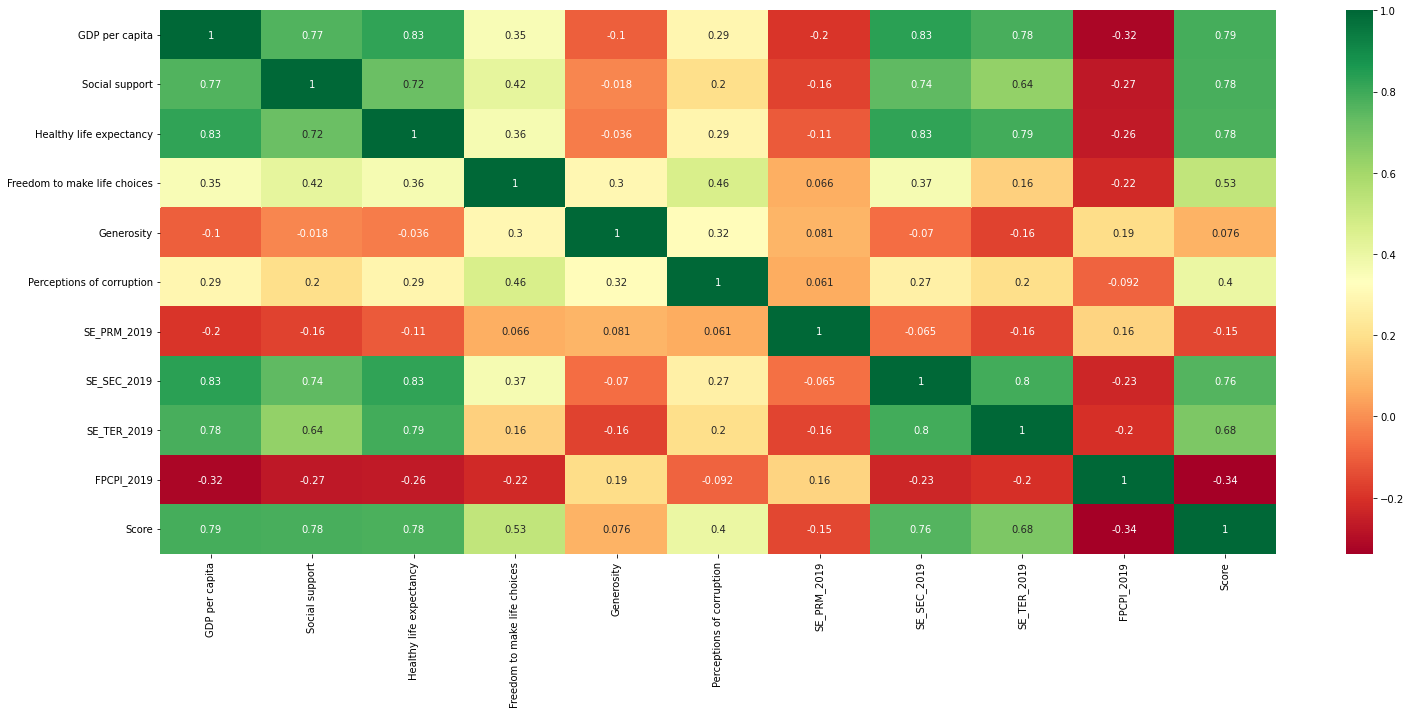

In [475]:
cor = WHR_std.corr()
plt.figure(figsize=(25,10))
sns.heatmap(cor, annot=True, cmap='RdYlGn')
plt.show() 

In [476]:
# sns.pairplot(WHR_std, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})



> We can see there are lot of co-relation among the variables. The co-relation between "**Healthy life expectancy**", "**GDP per capita**" and "**SE_SEC_2019**" being the highest, it may mean that essentially both are measuring or predicting same thing



### Part3 - P-value Analysis

In [477]:
import statsmodels.api as sm

model = sm.OLS(WHR_std["Score"], WHR_std[X]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Score   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              424.0
Date:                Sun, 18 Dec 2022   Prob (F-statistic):                    2.45e-98
Time:                        03:43:43   Log-Likelihood:                          127.75
No. Observations:                 148   AIC:                                     -235.5
Df Residuals:                     138   BIC:                                     -205.5
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
GDP per capita                   0.1299      0.085      1.527      0.129      -0.038       0.298
Social support                   0.2904      0.072      4.057      0.000       0.149       0.432
Healthy life expectancy          0.1426      0.086      1.662      0.099      -0.027       0.312
Freedom to make life choices     0.1506      0.054      2.812      0.006       0.045       0.256
Generosity                       0.0736      0.059      1.246      0.215      -0.043       0.190
Perceptions of corruption        0.1216      0.050      2.452      0.015       0.024       0.220
SE_PRM_2019                     -0.1272      0.055     -2.322      0.022      -0.236      -0.019
SE_SEC_2019                      0.1048      0.086      1.212      0.228      -0.066       0.276
SE_TER_2019                      0.1521      0.082      1.863      0.065      -0.009       0.314
FPCPI_2019                      -1.1783      0.461     -2.555      0.012      -2.090      -0.267
==============================================================================
Omnibus:                        7.744   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                7.906
Skew:                          -0.434   Prob(JB):                       0.0192
Kurtosis:                       3.726   Cond. No.                         84.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



> P-value in "**Generosity**" is the highest and high enough to define as insignificant for the response. I will remove it from the dataset.



In [478]:
# Drop unsignificant features
X.remove("Generosity")
# X.remove("SE_SEC_2019")

WHR_std.drop(["Generosity"], axis=1, inplace=True)
WHR_std


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,SE_PRM_2019,SE_SEC_2019,SE_TER_2019,FPCPI_2019,Score
0,Finland,0.795724,0.977217,0.864154,0.944532,0.867550,0.427324,0.920593,0.623931,0.016468,1.000000
1,Denmark,0.821259,0.968596,0.872918,0.938193,0.905077,0.431813,0.806711,0.548717,0.015439,0.965622
2,Norway,0.883610,0.974138,0.900964,0.955626,0.752759,0.431146,0.723591,0.558129,0.020891,0.956265
3,Iceland,0.819477,1.000000,0.899211,0.936609,0.260486,0.440764,0.700162,0.519952,0.024164,0.944060
4,Netherlands,0.828979,0.937192,0.875548,0.882726,0.657837,0.506156,0.839721,0.584297,0.022693,0.942840
...,...,...,...,...,...,...,...,...,...,...,...
144,Malawi,0.113420,0.344828,0.433830,0.702060,0.196468,1.000000,0.121969,0.006590,0.048752,0.113303
145,Rwanda,0.213183,0.437808,0.538124,0.879556,0.907285,0.827808,0.175347,0.037120,0.025456,0.097844
146,Tanzania,0.282660,0.544951,0.437336,0.660856,0.324503,0.380877,0.075829,0.015852,0.025906,0.076892
147,Afghanistan,0.207838,0.318350,0.316389,0.000000,0.055188,0.513877,0.257296,0.060472,0.021412,0.071196


## **Model Selection**

### Model 1: Linear Regression

In [500]:
train, test = train_test_split(WHR_std, test_size=0.2)


> Because the relationship plot of "**SE_PRM_2019**" and "**Score**" is highly unlinear, I decide to remove "**SE_PRM_2019**" from predictors.

In [501]:
X_tmp = copy.deepcopy(X)
X_tmp.remove("SE_PRM_2019")
X_tmp

['GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Perceptions of corruption',
 'SE_SEC_2019',
 'SE_TER_2019',
 'FPCPI_2019']

In [502]:
from sklearn.linear_model import LinearRegression 

poly = PolynomialFeatures(degree=1, include_bias=False)
X_train = poly.fit_transform(train[X_tmp].values.reshape(-1, 8))

polyReg = LinearRegression().fit(X_train, train[Y].values.reshape(-1, 1))

In [503]:
y_predict_train = polyReg.predict(X_train)
r2_score(train[Y], y_predict_train)

0.7749317319876463

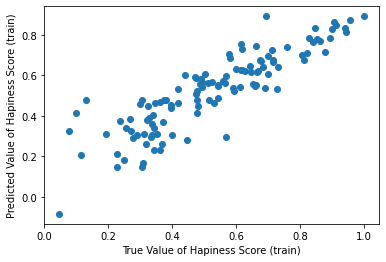

In [504]:
# Display the linear relationship between predicted value of train data and true value
plt.scatter(train[Y],y_predict_train)
plt.xlabel("True Value of Hapiness Score (train)")
plt.ylabel("Predicted Value of Hapiness Score (train)")
plt.show()

In [505]:
X_test = poly.fit_transform(test[X_tmp].values.reshape(-1, 8))

y_predict_test = polyReg.predict(X_test)
r2_score(test[Y],y_predict_test)

0.7985271924803632

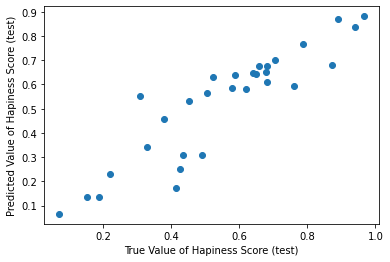

In [506]:
# display linear relationship between test predicted value and true value
plt.scatter(test[Y],y_predict_test)
plt.xlabel("True Value of Hapiness Score (test)")
plt.ylabel("Predicted Value of Hapiness Score (test)")
plt.show()



> **Consluion**: We can find that linear regression model can predict the trend of true value with R^2 of test dataset equal to 0.799. Linear regression is suitable to predict the happiness score given the current preditors. 

> To investigate more posibilities, in the next part, I will use Neural Network to build a new regression model.


### Model 2: Neural Network Model

In [507]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [508]:
X_train = train[X_tmp]
X_train = np.asarray(X_train)
X_train = torch.from_numpy(X_train).type(torch.float).unsqueeze(1)
y_train = train[Y]
y_train = np.asarray(y_train)
y_train = torch.from_numpy(y_train).type(torch.float).unsqueeze(1)

X_test = test[X_tmp]
X_test = np.asarray(X_test)
X_test = torch.from_numpy(X_test).type(torch.float).unsqueeze(1)
y_test = test[Y]
y_test = np.asarray(y_test)
y_test = torch.from_numpy(y_test).type(torch.float).unsqueeze(1)

In [509]:
# Construct Nerual Network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden_2, n_output):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(n_feature, n_hidden),  # n_feature x n_hidden
            torch.nn.Sigmoid(),
            torch.nn.Linear(n_hidden, n_hidden_2),  # n_hidden x n_hidden
            torch.nn.Sigmoid(),
            torch.nn.Linear(n_hidden_2, n_output)  # n_hidden x n_output -> 1x1
        )

    def forward(self, x):
        return self.layers(x)

In [511]:
# nn parameter 

epoches = 1001
# models = 10
net = Net(n_feature=8, n_hidden=100,n_hidden_2=50, n_output=1)
# print(net)
optimizer = torch.optim.SGD(
    net.parameters(), lr=0.08, momentum=0.5, weight_decay=0)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

In [512]:
y_prediction_train=[]
# Train nn 
for t in range(epoches):
    y_prediction_train = net(X_train)

    loss = loss_func(y_prediction_train, y_train)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

In [513]:
y_pred_train = []
y_pred_train =  net(X_train)
y_pred_train = y_pred_train.detach().numpy()
y_pred_train = np.asarray(y_pred_train)
y_pred_train = np.transpose(y_pred_train)

In [514]:
r2_score(train[Y],y_pred_train[0][0])

0.7389864911357699

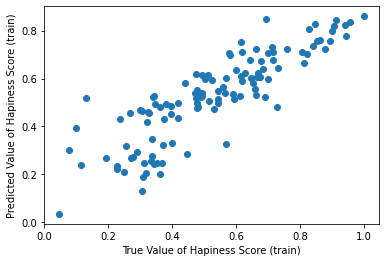

In [515]:
plt.scatter(train[Y],y_pred_train[0][0])

plt.xlabel("True Value of Hapiness Score (train)")
plt.ylabel("Predicted Value of Hapiness Score (train)")
plt.show()

In [516]:
y_pred_test = []
y_pred_test =  net(X_test)
y_pred_test = y_pred_test.detach().numpy()
y_pred_test = np.asarray(y_pred_test)
y_pred_test = np.transpose(y_pred_test)

In [517]:
r2_score(test[Y],y_pred_test[0][0])

0.7893370447191885

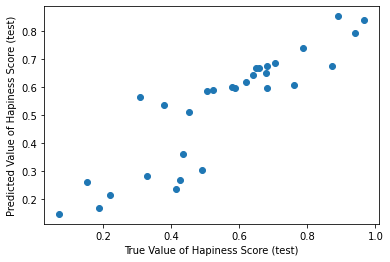

In [518]:
plt.scatter(test[Y],y_pred_test[0][0])

plt.xlabel("True Value of Hapiness Score (test)")
plt.ylabel("Predicted Value of Hapiness Score (test)")
plt.show()

>  **Conclusion**: The R^2 of NN model on train dataset and test dataset are similar (~0.78), suggesting that overfitting is not a problem here. 

> The R^2 of the NN model on test dataset is 0.789, which is lower than that of linear regression model.

> Considering the simplicity of linear regression model, I recommend using linear regression as the predictve model rather than the neural network regression model. 





## **Report Conclusion**

We explore the World Happiness Report containing data from 150 countries in the world. In addition to the 6 life indicators that come with whr, we also introduced 3 education level indicators and 1 price level indicator into the analysis.

At last, we can conclude that social support, healthy lif expecatncy, GDP per capita, freedom to make life choices and preceptions of curruption can help you live relatively happy life. Besides that, to a certain extent, the enrollment of schools at each stage can also roughly reflect the life happiness of the country's citizens. For the CPI indicator, people in a country with a low CPI are more likely to feel happier than people in a country with a high CPI, but CPI is not an indicator that can effectively measure happiness in life.